In [3]:
"""Librairies nécessaires"""

import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

from shapely.geometry import Point
from shapely.ops import nearest_points

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

In [4]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [5]:
"""Lecture du fichier transports"""

emplacement = '3.0) Enrichissement données/Données/Transports_idf.geojson'

df = gpd.read_file(emplacement, low_memory=False, index_col=0)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [6]:
df_transport = df.copy()

In [7]:
"""Modifications du fichier"""

var_interet = ['nom_gares', 'nom_so_gar', 'nom_su_gar', 'idrefligc', 'res_com', 'indice_lig', 'mode', 'tertrain', 'terrer',
       'termetro', 'tertram', 'terval', 'exploitant', 'idf', 'geometry']

df_transport = df_transport.loc[:, var_interet]

#création de sous dataframes selon le type de transport
df_metro = df_transport.loc[df_transport['mode']=='METRO']
df_rer = df_transport.loc[df_transport['mode']=='RER']
df_tram = df_transport.loc[df_transport['mode']=='TRAMWAY']

#réduction du df
df_transport = df_transport.loc[df_transport['mode'].isin(['METRO', 'RER', 'TRAMWAY'])]

In [8]:
"""Chargement des fonds de carte géographiques"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')

paris_quartiers = gpd.read_file('2) Visualisation/Données_carto/paris_quartiers.geojson')
paris_quartiers = paris_quartiers[['c_quinsee', 'l_qu', 'geometry']]

petite_couronne = gpd.read_file('2) Visualisation/Données_carto/petite_couronne.geojson')

idf = gpd.read_file('2) Visualisation/Données_carto/idf.geojson')

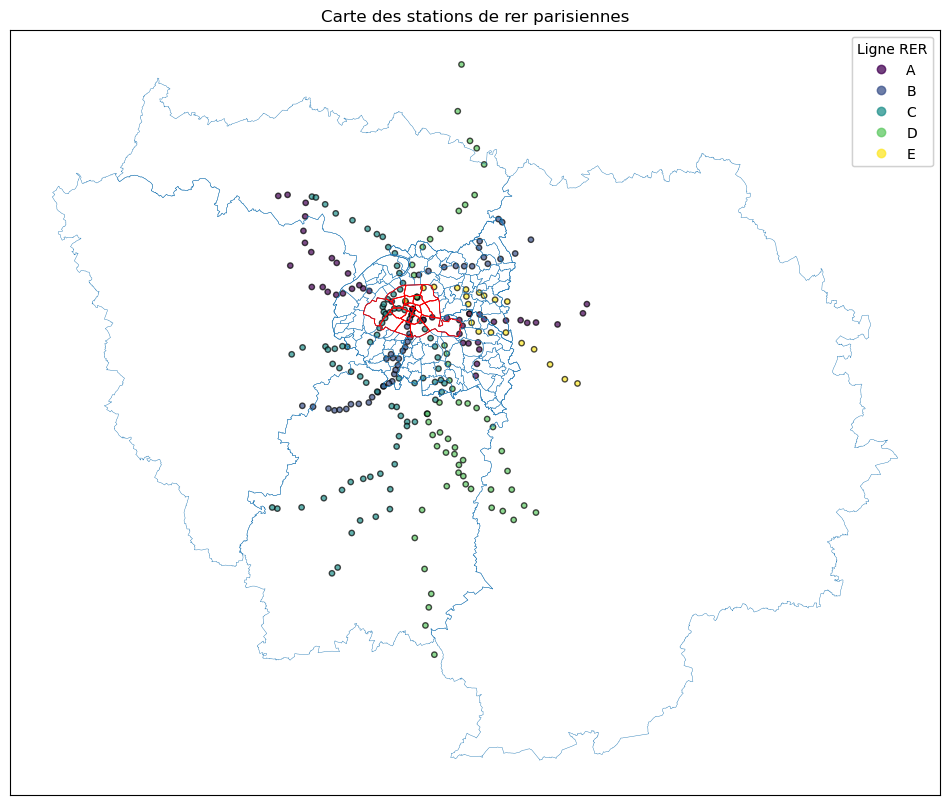

In [28]:
"""Visualisation des stations RER"""

fig, ax = plt.subplots(figsize=(12, 14))

idf.boundary.plot(ax=ax, linewidth=0.3, facecolor='none')

petite_couronne.boundary.plot(ax=ax, linewidth=0.3)  # on plot les frontières de la petite couronne

paris_arrondissement.boundary.plot(ax=ax, edgecolor="red", linewidth=0.7)  # on ajout les arrondissements parisiens en rouge

# Utilisation de LabelEncoder pour convertir les catégories en nombres
le = LabelEncoder()
df_rer['indice_lig_encoded'] = le.fit_transform(df_rer['indice_lig'])

# Création d'une correspondance entre les valeurs originales de 'indice_lig' et les lettres correspondantes
correspondance = {val: chr(ord('A') + num) for num, val in enumerate(le.classes_)}

# Utilisation de scatter avec les couleurs codées
scatter = ax.scatter(df_rer['geometry'].x, df_rer['geometry'].y, c=df_rer['indice_lig_encoded'], cmap='viridis', s=15, edgecolors='black', alpha=0.7)

# Ajouter une légende pour 'indice_lig'
legend_labels = [correspondance[val] for val in le.classes_]
legend = ax.legend(handles=scatter.legend_elements()[0], title='Ligne RER', labels=legend_labels)

# Ajouter la légende sur la droite du graphique
ax.add_artist(legend)

# rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

# titre
plt.title('Carte des stations de rer parisiennes')

# Export du graphique
fig.savefig('3.0) Enrichissement données/Sorties_cartes/stations_rer_idf', bbox_inches='tight', pad_inches=0.1)

plt.show()


/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


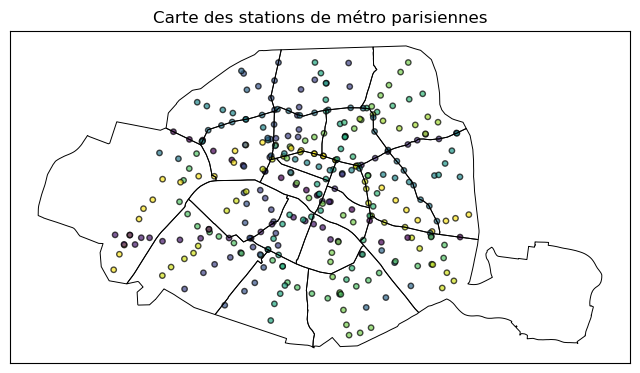

In [27]:
"""Visualisation des stations de métro dans paris intra muros"""

# Filtrer les stations de métro qui sont situées à l'intérieur de Paris
df_metro_paris = df_metro[df_metro['geometry'].within(paris_arrondissement.unary_union)]

fig, ax = plt.subplots(figsize=(8, 10))

#petite_couronne.boundary.plot(ax=ax, linewidth=0.3)
paris_arrondissement.boundary.plot(ax=ax, edgecolor="black", linewidth=0.7)

# Utilisation de LabelEncoder pour convertir les catégories en nombres
le = LabelEncoder()
df_metro_paris['indice_lig_encoded'] = le.fit_transform(df_metro_paris['indice_lig'])

# Utilisation de scatter avec les couleurs codées
scatter = ax.scatter(df_metro_paris['geometry'].x, df_metro_paris['geometry'].y, c=df_metro_paris['indice_lig_encoded'], cmap='viridis', s=15, edgecolors='black', alpha=0.7)

# rien sur les axes
plt.xticks([], [])
plt.yticks([], [])

# titre
plt.title('Carte des stations de métro parisiennes')

# Export du graphique
fig.savefig('3.0) Enrichissement données/Sorties_cartes/stations_metro_paris', bbox_inches='tight', pad_inches=0.1)

plt.show()


In [67]:
"""Fonction qui merge les data set en trouvant la station (point) la plus proche et 
enregistre la distance (en km)"""

def ajout_stat_trans(dvf, df_transport):

    #sélection des variables
    var_transport = ['nom_gares', 'indice_lig', 'geometry']
    df_transport = df_transport[var_transport].copy()
    df_transport = df_transport.drop_duplicates(['geometry'])

    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_transport = df_transport.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_transport, how="left", max_distance=5000, distance_col="dist_min_stat")

    #dist en km
    merged_nearest['dist_min_stat'] = merged_nearest['dist_min_stat']/1000

    #repasser en système de projection wgs 84
    dvf_avec_transport = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_transport = dvf_avec_transport.drop(['index_right'], axis=1)    
    dvf_avec_transport = dvf_avec_transport.rename(columns={'nom_gares': 'nom_stat', 'indice_lig': 'num_ligne'})

    return dvf_avec_transport

In [54]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)


In [64]:
"""Ajout des transports"""

dvf_avec_transport = ajout_stat_trans(dvf, df_transport)

In [66]:
"""Exportation"""

#chemin export
outer_path = '3.1) Données enrichies/'
outer_name = 'dvf_concat_2021_to_2023_avec_transports.geojson'

#exportation
dvf_avec_transport.to_file(outer_path+outer_name, driver='GeoJSON')

====================================================

Ci-dessous : ancienne méthode

====================================================

In [36]:
"""On créée une fonction qui ajoute à chaque appartement la station de métro la plus proche : 
le nom, le numéro de ligne, la distance"""

def ajouter_transport(dvf, df_transport):
    
    #dvf : geodataframe contenant la localisation de l'appartement dans une colonne 'geometry' au format WSG84
    #df_transport : geodataframe contenant la localisation des stations de métro dans une colonne 'geometry' au format WSG84

    #la fonction ajoute trois colonnes à dvf : closest_stat, dist_metro_min, num_ligne
    
    # Convertir la colonne 'geometry' en type Point
    dvf['geometry'] = dvf['geometry'].apply(Point)
    df_transport['geometry'] = df_transport['geometry'].apply(Point)
    
    # Définir la projection équidistante (EPSG:3395)
    dvf = dvf.to_crs(epsg=3395)
    df_transport = df_transport.to_crs(epsg=3395)
        
    # Fonction pour trouver la station de métro la plus proche
    def find_nearest_station(row):
        nearest_station = df_transport.geometry == nearest_points(row['geometry'], df_transport.unary_union)[1]
        return pd.Series({
            'closest_stat': df_transport.loc[nearest_station, 'nom_gares'].values[0],
            'dist_min_stat': row['geometry'].distance(df_transport.loc[nearest_station, 'geometry'].values[0]) / 1000,  # Conversion en kilomètres
            'num_ligne': df_transport.loc[nearest_station, 'indice_lig'].values[0]
        })
    
    # Appliquer la fonction pour chaque appartement
    tqdm.pandas()  # Barre de progression pour les itérations
    dvf[['closest_stat', 'dist_min_stat', 'num_ligne']] = dvf.progress_apply(find_nearest_station, axis=1)

    # Reconvertir en WGS 84 (EPSG:4326)
    dvf_result = dvf.to_crs(epsg=4326)
    
    return dvf_result

In [37]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données_concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)

#chemin export
outer_path = '3.1) Données_enrichies/'

In [38]:
"""Fonction qui applique ajouter_transport et exporte le fichier"""

def ajout_transport_export(dvf, outer_path):

    #on applique la fonction ajouter_transport
    dvf_enrichi = ajouter_transport(dvf, df_transport)

    #nom du fichier de sortie
    name_file_without_extension = os.path.splitext(name_file)[0]
    outer_name = f'{name_file_without_extension}_avec_transports.geojson'

    #on exporte
    dvf_enrichi.to_file(outer_path+outer_name, driver='GeoJSON')

In [39]:
"""Ajouter les transports au fichier dvf"""

ajout_transport_export(dvf, outer_path)

/opt/mamba/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/opt/mamba/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
100%|██████████| 59417/59417 [36:38<00:00, 27.02it/s]  
